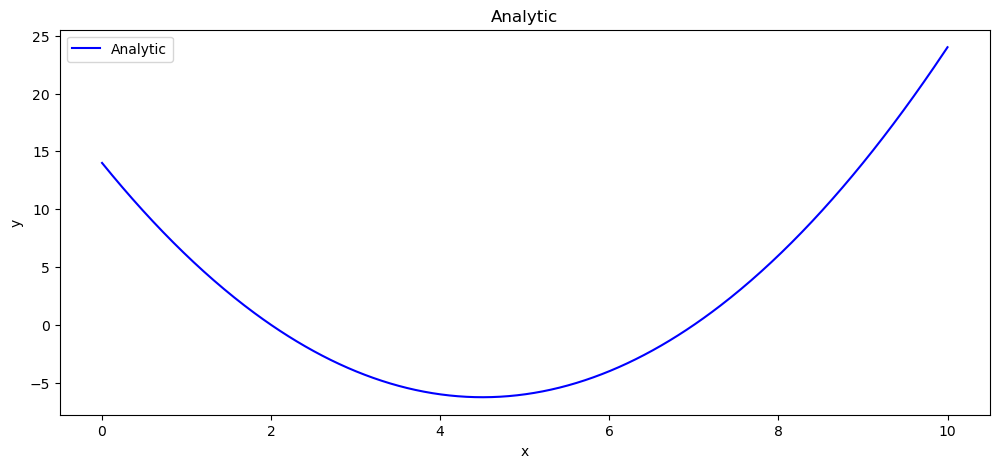

In [141]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=4)

f_true = lambda x: x**2 - 9*x + 14

sigma = 2

X_test = np.linspace(0,10,500)

Y_true = np.array([f_true(xt) for xt in X_test])


# Plotting
plt.figure(figsize=(12, 5))
plt.plot(X_test, Y_true, label="Analytic", color="blue")


plt.title(f"Analytic")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
# fig_name = f"c1_pce_{n}p{degree}d"
# plt.savefig('figs/'+fig_name)
plt.show()

In [142]:
# data generation
X_train = np.arange(0,11,2)

n = len(X_train)
num_rep = 10

# Generate replicates at each design point
output_raw = np.array([f_true(x) + sigma * np.random.normal(loc=0, scale=sigma, size=num_rep) for x in X_train])

# Calculate training output mean
Y_train = np.mean(output_raw, axis=1)

# Calculate variance at each design point
V_train = np.var(output_raw, axis=1, ddof=1)  # ddof=1 for sample variance

In [143]:
X_train, Y_train, V_train

(array([ 0,  2,  4,  6,  8, 10]),
 array([12.7342, -0.4615, -7.8235, -3.4308,  5.3611, 22.7824]),
 array([22.6954,  4.7204, 10.0746,  7.1199, 10.294 , 15.4577]))

In [144]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Gaussian Process with RBF Kernel
class StochasticKriging:
    def __init__(self):
        self.length_scale = 1.0
        self.sigma_f = 1.0
        self.sigma_noise = 0.5

    def rbf_kernel(self, X1, X2):
        # Ensure X1 and X2 are 2D column vectors
        X1 = X1.reshape(-1, 1)
        X2 = X2.reshape(-1, 1)

        # Calculate the squared Euclidean distance
        sqdist = np.sum((X1 - X2.T)**2, axis=1)
        return self.sigma_f**2 * np.exp(-0.5 / self.length_scale**2 * sqdist)

    def train(self, X_train, Y_train, V_train):
        """
        X_train: design points at which observations were made
        Y_train: output mean at a design points
        V_train: variance at a design points(obtained from replications)
        """
        self.X_train = X_train
        self.Y_train = Y_train
        self.V_train = V_train
        self.C = np.diag(V_train)
        self.K = self.rbf_kernel(X_train, X_train) + self.sigma_noise**2 * np.eye(len(X_train))
        self.L = np.linalg.cholesky(self.K+self.C)
        z = np.linalg.solve(self.L, Y_train)
        self.W = np.linalg.solve(self.L.T, z)

    def predict(self, X_s):
        # reeturn mu_s. std
        K_s = self.rbf_kernel(self.X_train, X_s)
        mu_s = np.dot(K_s.T, self.W)

        # Compute the variance at our test points.
        Lk = np.linalg.solve(self.L, K_s)
        K_ss = self.rbf_kernel(X_s, X_s)

        s2 = np.diag(K_ss) - np.sum(Lk**2, axis=0)
        stdv = np.sqrt(s2)

        return mu_s, stdv

# Negative log-likelihood for the GP model
def nll_fn(skg, X_train, Y_train, V_train):
    def nll(theta):
        # Update the model with new parameters
        skg.length_scale, skg.sigma_f, skg.sigma_noise = theta[0], theta[1], theta[2]
        skg.train(X_train, Y_train, V_train)
        L = skg.L

        # Compute the negative log likelihood
        return np.sum(np.log(np.diagonal(L))) + \
               0.5 * Y_train.T.dot(np.linalg.solve(L.T, np.linalg.solve(L, Y_train))) + \
               0.5 * len(X_train) * np.log(2 * np.pi)
    return nll

In [145]:
## Using my own implementation
# Optimization of hyperparameters including sigma_noise
initial_params = [1, 1, 0.5]  # Initial guesses for length_scale, sigma_f, and sigma_noise
bounds = ((1e-5, None), (1e-5, None), (1e-5, None))  # Allow sigma_noise to vary freely

# Initialize and train GP model
skg = StochasticKriging()
res = minimize(nll_fn(skg, X_train, Y_train, V_train), initial_params, bounds=bounds, method='L-BFGS-B')

# Update GP model with optimized length scale and sigma_f
skg.length_scale, skg.sigma_f, skg.sigma_noise = res.x

[[-1.4838e-212 -1.4838e-212 -1.4838e-212 ... -1.4838e-212 -1.4838e-212
  -1.4838e-212]
 [-1.4838e-212 -1.4838e-212 -1.4838e-212 ... -1.4838e-212 -1.4838e-212
  -1.4838e-212]
 [-1.4838e-212 -1.4838e-212 -1.4838e-212 ... -1.4838e-212 -1.4838e-212
  -1.4838e-212]
 ...
 [-1.4838e-212 -1.4838e-212 -1.4838e-212 ... -1.4838e-212 -1.4838e-212
  -1.4838e-212]
 [-1.4838e-212 -1.4838e-212 -1.4838e-212 ... -1.4838e-212 -1.4838e-212
  -1.4838e-212]
 [-1.4838e-212 -1.4838e-212 -1.4838e-212 ... -1.4838e-212 -1.4838e-212
  -1.4838e-212]]


/var/folders/vx/g3t3vb8n4xz_zf9hmwjdt6hc0000gn/T/ipykernel_44160/95999301.py:45: RuntimeWarning: invalid value encountered in sqrt
  stdv = np.sqrt(s2)


ValueError: x and y must have same first dimension, but have shapes (50, 1) and (1,)

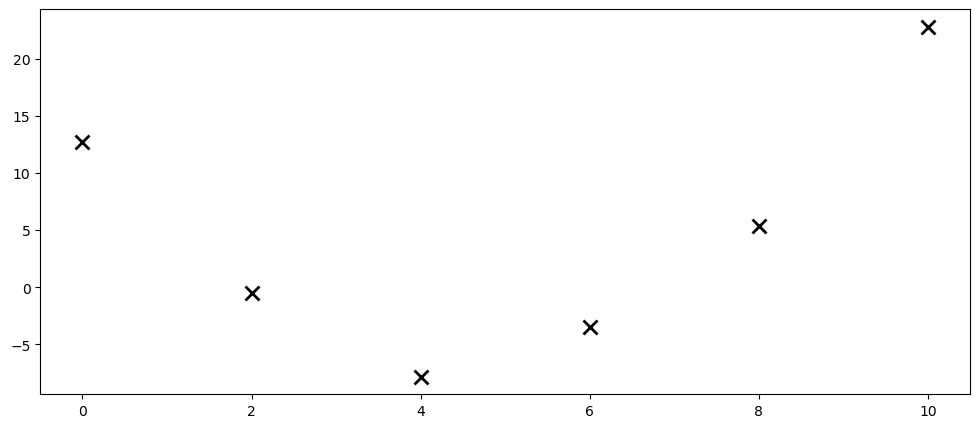

In [146]:
# Predict at new data points
X_new = np.linspace(0, 10, 50).reshape(-1, 1)  # Test inputs
Y_pred, Y_var = skg.predict(X_new)  # Predictive mean and variance
Y_true = np.array([f_true(xn) for xn in X_new])

# Plotting
plt.figure(figsize=(12, 5))
plt.plot(X_train, Y_train, 'kx', markersize=10, markeredgewidth=2, label="Data")

plt.plot(X_new, Y_pred, label='Mean Prediction', color='orange')
plt.plot(X_new, Y_true, label="True Function", color="blue")
plt.fill_between(X_new.flatten(), (Y_pred - 2*np.sqrt(Y_var)).flatten(), (Y_pred + 2*np.sqrt(Y_var)).flatten(), color='orange',
                 alpha=0.2, label='95% Confidence Interval')
plt.fill_between(X_new.flatten(), (Y_true - 2*sigma).flatten(), (Y_true + 2*sigma).flatten(), color='blue',
                 alpha=0.2, label='95% Confidence Interval(theoretical)')
plt.title(f"Gaussian Process Regression with GPy")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()